# Major Depressive Disorder Diagnosis

 - - -

## Previous Research Summary

Title: "Heart rate variability for treatment response between patients with major depressive disorder versus panic disorder: A 12-week follow-up study" (K.W. Choi et al.)
> Hypothesis #1: Patients with MDD and PD showed differenct HRV profiles compared to healthy controls. \
> Hypothesis #2: It is possible to predict the responder groups in the MDD and PD patients, using differences in HRV indicies between the stress and rest phases. \
> Methods: 28 MDD patients, 29 PD patients, 39 healthy control subjects - for 12 weeks follow-up. \
> Results: 
>> pNN50 --- Patients with MDD and PD demonstrated lower pNN50. \
>> LF/HF ratio --- Patients with MDD and PD showed higher LF/HF ratio than control during 'stress' phase. \
>> LF/HF ratio --- Responders in the PD group showed lower LF/HF ratio during 'stress' phase compared to non-responders. \
>> Heart Rate --- Responders in the MDD group showed lower heart rate during 'all three' phases compared to non-responders. \
>> LF/HF ratio and pNN50 --- Possible to predict treatment response in patients with MDD using LF/HF ratio and pNN50. \

> Variables(time-domain): \
>> SDNN (Standard deviation of average normal-normal intervals) -- sympathetic and parasympathetic activities. \
>> RMSSD (Root mean square of successive differences) -- parasympathetic modulation. \
>> pNN50 -- parasympathetic modulation. \

> Variables(frequency-domain): \
>> LF (low frequency, 0.04 ~ 0.15 Hz) -- modulated by sympathetic and parasympathetic activities. \
>> HF (high frequency, 0.15 ~ 0.4 Hz) -- modulated by parasympathetic activities. \
>> LF/HF ratio -- ratio of LF and HF -- measures balance between sympathetic and parasympathetic activities. \

- - -

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [4]:
class Args:
    # arugments
    epochs=50
    bs=16
    lr=0.001
    momentum=0.9
    num_classes=3
    verbose='store_true'
    seed=674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

In [5]:
#Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


- - -

# Data Handling

## Dataset check

In [6]:
# HRV 데이터셋 불러오기
hrv_df = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_samsung/HRV_REV_all.csv', sep=',')
hrv_df.head()

,sub,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
0,E001,4,2,23,1,2,2,1,12,22,...,41.544667,190.107000,298.508333,206.862333,1.284000,695.477333,65.707000,14.054333,3.911333,34.998000
1,E001,5,2,23,1,12,7,0,12,24,...,39.825333,143.756667,115.695333,202.602667,0.585000,462.054667,69.040000,14.117333,6.255000,35.544333
2,E002,1,2,38,1,14,17,14,31,122,...,20.052000,22.006000,50.182000,32.529333,2.499333,104.717000,92.789333,11.013333,0.945667,35.086000
3,E002,2,2,38,1,13,36,16,32,139,...,20.201667,55.579000,84.441000,18.754000,5.803000,158.774333,85.980667,12.608333,0.785667,36.141000
4,E002,3,2,38,1,7,10,11,23,70,...,74.788000,182.229000,530.565667,546.574000,1.685667,1259.368667,84.368667,14.285667,0.648000,35.879000


In [7]:
hrv_df.shape

(479, 93)

HRV measuring steps
* b1 - s - b2 - r - b3 - c
* Phase: b(baseline between each phase), s(stress phase), r(relaxation phase), c(recovery phase)
* Disorder(=label): 1(Depression), 2(Panic Disorder), 3(Control)
* Each has following variables (Total 13 variables)
> SDNN, NN50, PNN50, RMSSD, VLF, LF, HF, LF/HF, POWER, HR, RESP, SC, TEMP

In [8]:
hrv_df.columns

Index(['sub', 'VISIT', 'disorder', 'age', 'gender', 'HAMD', 'HAMA', 'PDSS',
       'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI', 'b1SDNN', 'b1NN50',
       'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF', 'b1LF/HF', 'b1POWER',
       'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN', 'sNN50', 'sPNN50',
       'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER', 'sHR', 'sRESP',
       'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50', 'b2RMSSD', 'b2VLF',
       'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR', 'b2RESP', 'b2SC',
       'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD', 'rVLF', 'rLF', 'rHF',
       'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC', 'rTEMP', 'b3SDNN', 'b3NN50',
       'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF', 'b3HF', 'b3LF/HF', 'b3POWER',
       'b3HR', 'b3RESP', 'b3SC', 'b3TEMP', 'cSDNN', 'cNN50', 'cPNN50',
       'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF', 'cPOWER', 'cHR', 'cRESP',
       'cSC', 'cTEMP'],
      dtype='object')

In [9]:
hrv_df["disorder"].value_counts() ## MDD 136, PD 149, Control 194

3    194
2    149
1    136
Name: disorder, dtype: int64

- - -

## Data preprocessing

* Select the analysis task
> MDDPD, MDDC, PDC, none

In [14]:
## Select the task to be analyzed
# task = "MDDC"
task = "NONE"

In [15]:
if task == "MDDPD":
    hrv = hrv_df[hrv_df["disorder"].isin([1,2])] ## for MDD vs PD task
elif task == "MDDC":
    hrv = hrv_df[hrv_df["disorder"].isin([1,3])] ## for MDD vs Control task
elif task == "PDC":
    hrv = hrv_df[hrv_df["disorder"].isin([2,3])]       ## for PD  vs Control task
else:
    hrv = hrv_df ## for MDD vs PD vs Control task

In [16]:
hrv.shape

(479, 93)

In [17]:
## scaler setting for data standardization.
scaler = MinMaxScaler()

In [18]:
## Separating HRV dataset by experimental steps.
hrv_only = hrv.drop(columns=['sub', 'VISIT', 'disorder', 'age','gender','HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ','PSWQ','SPI','PSS','BIS','SSI']) ##leave the variables only about HRV features.
hrv_only[:] = scaler.fit_transform(hrv_only[:])  ##Standardizing. if not necessary, delete.  
hrv_b1 = hrv.filter(regex='^b1')
hrv_s = hrv.filter(regex='^s')
hrv_b2 = hrv.filter(regex='^b2')
hrv_r = hrv.filter(regex='^r')
hrv_b3 = hrv.filter(regex='^b3')
hrv_c = hrv.filter(regex='^c')

In [26]:
hrv_only.head()

,b1SDNN,b1NN50,b1PNN50,b1RMSSD,b1VLF,b1LF,b1HF,b1LF/HF,b1POWER,b1HR,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
0,0.075757,0.344,0.495745,0.054862,0.000710,0.000565,0.003834,0.007478,0.001303,0.145328,...,0.047600,0.001651,0.001531,0.001556,0.026915,0.001560,0.219382,0.553832,0.264775,0.879143
1,0.064662,0.328,0.446809,0.044981,0.000722,0.001170,0.002868,0.027090,0.001374,0.192303,...,0.045500,0.001244,0.000591,0.001524,0.010246,0.001029,0.259603,0.561629,0.424709,0.927001
2,0.034528,0.000,0.000000,0.012500,0.000932,0.000505,0.000515,0.091000,0.000661,0.549465,...,0.021346,0.000173,0.000254,0.000241,0.055897,0.000216,0.546196,0.177502,0.062395,0.886851
3,0.031088,0.000,0.000000,0.010866,0.000941,0.001012,0.000574,0.151341,0.000902,0.525489,...,0.021529,0.000469,0.000430,0.000138,0.134680,0.000339,0.464033,0.374887,0.051476,0.979268
4,0.116386,0.144,0.141135,0.087233,0.000600,0.001868,0.003691,0.023884,0.001814,0.539072,...,0.088209,0.001582,0.002726,0.004118,0.036494,0.002843,0.444581,0.582460,0.042082,0.956317


In [20]:
hrv_only.shape

(479, 78)

In [21]:
## Check whethere each phase contains the same variables.
print("HRV baseline #1 shape is:", hrv_b1.shape[1])
print("HRV stress shape is:", hrv_s.shape[1])
print("HRV baseline #2 shape is:", hrv_b2.shape[1])
print("HRV rest shape is:", hrv_r.shape[1])
print("HRV baseline #3 shape is:", hrv_b3.shape[1])
print("HRV c shape is:", hrv_b1.shape[1])

HRV baseline #1 shape is: 13
HRV stress shape is: 14
HRV baseline #2 shape is: 13
HRV rest shape is: 13
HRV baseline #3 shape is: 13
HRV c shape is: 13


In [22]:
hrv_s = hrv_s.drop(columns=['sub'])

In [23]:
## Renaming the columns for further calculation.
## We need to generate new dataframes to compare the phases.
hrv_sub = hrv.loc[:, ['sub']]
hrv_disorder = hrv.loc[:,['disorder']] -1 ## 0(Depression), 1(Panic Disorder), 2(Control)
hrv_gender = hrv.loc[:,['gender']]
hrv_HAMD = hrv.loc[:,['HAMD']]
hrv_PDSS = hrv.loc[:,['PDSS']]

hrv_variables = ["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"]
hrv_b1_rename = hrv_b1.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_b2_rename = hrv_b2.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_b3_rename = hrv_b3.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_s_rename = hrv_s.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_r_rename = hrv_r.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_c_rename = hrv_c.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)

In [24]:
hrv_disorder.value_counts()

disorder
2           194
1           149
0           136
dtype: int64

- - -

## Comparisons between Phases

* HRV measuring steps: b1 - s - b2 - r - b3 - c
* Each has following variables (Total 13 variables): SDNN, NN50, PNN50, RMSSD, VLF, LF, HF, LF/HF, POWER, HR, RESP, SC, TEMP

Since the experimental phase steps are "b1-s-b2-r-b3-c", there are total 5 between phases

### 1) Baseline 1 - Stress phase

In [62]:
hrv_b1_s_sub = hrv_b1_rename - hrv_s_rename
hrv_b1_s_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,0.287667,4.666667,0.086333,10.664333,-2.756000,-279.967000,184.906667,-2.611000,-97.816333,-4.520333,2.624333,-4.828000,1.002000
1,-21.138333,3.666667,0.070667,-24.260667,-373.648667,-1140.831334,-1154.247667,-1.071333,-2668.727667,-8.211000,1.535000,-9.487000,0.614000
2,2.049333,0.000000,0.000000,-1.726000,76.143333,-29.314667,-26.714333,1.287667,20.114667,-2.449667,2.892333,-0.319667,-0.020333
3,6.312333,0.000000,0.000000,1.099333,98.432667,136.848000,24.599000,2.798000,259.880333,-0.202667,4.266333,-0.033667,-0.057667
4,28.445667,3.000000,0.032667,43.376000,57.050333,46.734333,59.237667,-0.705667,163.023000,2.514667,3.533000,-0.017000,-0.001000


### 2) Stress - Baseline 2 phase

In [63]:
hrv_s_b2_sub = hrv_s_rename - hrv_b2_rename
hrv_s_b2_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,-11.360000,-5.333333,-0.096667,-18.286000,-58.710000,-66.028667,-406.971333,2.004000,-531.710000,4.353333,-1.105333,-0.297667,-0.856667
1,9.035667,-4.333333,-0.080333,20.483333,234.864333,1052.266334,993.647000,1.265333,2280.777667,8.344667,0.931000,2.270000,0.033667
2,2.347000,0.000000,0.000000,3.369000,13.332333,71.931667,45.656333,-0.551333,130.920000,3.359667,-1.622667,0.132000,0.003000
3,-5.727667,0.000000,0.000000,-2.342667,-48.445667,-33.052000,-11.412000,0.121000,-92.909667,4.459000,-3.775667,0.003333,-0.043667
4,25.174667,1.666667,0.018333,16.042000,-6.794000,182.404333,200.162000,-0.467333,375.771667,2.845333,-3.480667,-0.013333,-0.057667


### 3) Baseline2 - Rest phase

In [64]:
hrv_b2_r_sub = hrv_b2_rename - hrv_r_rename
hrv_b2_r_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,10.395333,-1.000000,-0.012000,6.659000,-44.986000,-60.517000,89.346333,-0.140000,-16.157000,-0.738333,-0.327333,2.811667,-0.516667
1,8.564000,2.333333,0.038667,4.713000,88.049333,-244.483333,115.041667,-0.824333,-41.393000,-1.832333,-0.871000,4.765000,-0.102333
2,3.167333,0.000000,0.000000,0.588667,-18.453333,-2.815667,-6.873333,0.441000,-28.142000,-2.467333,0.249667,0.058333,0.066000
3,-10.102333,-1.000000,-0.012000,-6.834000,7.107667,-150.309000,-52.806333,-0.724000,-196.007667,2.282000,0.243467,-0.048667,0.001667
4,-60.977000,-1.333333,-0.016333,-79.491000,-46.755667,-70.231333,-440.990333,1.082333,-557.976667,1.675667,-0.406267,-0.018333,-0.025000


### 4) Rest - Baseline 3 phase

In [65]:
hrv_r_b3_sub = hrv_r_rename - hrv_b3_rename
hrv_r_b3_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,0.013000,3.000000,0.052333,4.031000,103.554000,184.618000,56.917333,0.183000,345.089000,-1.751333,-0.039000,0.217000,0.008000
1,-10.302000,4.000000,0.066667,2.679000,-335.397667,-1035.652000,-117.790667,-1.463000,-1488.840000,-3.499333,-0.183000,0.000333,0.033667
2,-6.370000,0.000000,0.000000,-0.883333,-9.966667,-36.395667,0.591667,-0.573000,-45.771000,0.824667,0.156333,0.031000,-0.006333
3,2.291667,0.333333,0.004000,0.361000,-9.414000,29.256667,20.084333,-0.369000,39.926667,0.664667,0.459533,-0.097667,0.031000
4,22.474000,-2.000000,-0.024000,29.576000,-33.946333,-416.315333,-38.017000,-0.863333,-488.278333,1.778333,1.090933,-0.048000,0.232333


### 5) Baseline 3 - Recovery phase

In [66]:
hrv_b3_c_sub = hrv_b3_rename - hrv_c_rename
hrv_b3_c_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,12.304667,5.000000,0.082000,11.538000,-87.053000,22.708667,183.949333,-0.400667,119.605667,-2.086000,0.554000,-0.973000,0.049667
1,11.430000,0.000000,-0.000333,3.136000,344.203333,1457.863334,196.513333,2.423000,1998.580333,0.804333,-0.045667,-3.214333,-0.499667
2,5.140667,-0.333333,-0.003667,-6.298333,47.976667,35.215667,-2.485667,-0.249000,80.707333,0.584667,4.988667,-0.041000,0.039000
3,7.316333,0.666667,0.008000,1.034000,28.962333,110.159333,48.298000,-2.942667,187.419333,-2.421667,4.454000,0.009333,0.096667
4,-4.424000,-4.333333,-0.051333,3.227667,-66.960667,53.581000,-23.631000,0.085667,-37.011334,-1.356000,2.324333,-0.033333,-0.065667


### 6) Stress - Rest phase

* This is what SMC checks for the research

In [67]:
hrv_s_r_sub = hrv_s_rename - hrv_r_rename
hrv_s_r_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,-0.964667,-6.333333,-0.108667,-11.627000,-103.696000,-126.545667,-317.625000,1.864000,-547.867000,3.615000,-1.432667,2.514000,-1.373333
1,17.599667,-2.000000,-0.041667,25.196333,322.913667,807.783000,1108.688667,0.441000,2239.384667,6.512333,0.060000,7.035000,-0.068667
2,5.514333,0.000000,0.000000,3.957667,-5.121000,69.116000,38.783000,-0.110333,102.778000,0.892333,-1.373000,0.190333,0.069000
3,-15.830000,-1.000000,-0.012000,-9.176667,-41.338000,-183.361000,-64.218333,-0.603000,-288.917333,6.741000,-3.532200,-0.045333,-0.042000
4,-35.802333,0.333333,0.002000,-63.449000,-53.549667,112.173000,-240.828333,0.615000,-182.205000,4.521000,-3.886933,-0.031667,-0.082667


- - -

## Data preprocessing for ML

* The "hrv_only" data shows all hrv features from all three phases

In [28]:
hrv_only.shape

(479, 78)

In [29]:
hrv_arr = hrv_only.values
hrv_arr.shape

(479, 78)

In [33]:
hrv_arr[0]

array([7.57572050e-02, 3.43999725e-01, 4.95744681e-01, 5.48618085e-02,
       7.10357963e-04, 5.65109044e-04, 3.83375473e-03, 7.47808460e-03,
       1.30291727e-03, 1.45327715e-01, 7.25296070e-01, 7.06635623e-02,
       8.41094174e-01, 8.10983949e-02, 2.31999814e-01, 3.26409738e-01,
       5.04428727e-02, 2.13408362e-03, 3.17540086e-03, 2.40447750e-03,
       1.39438493e-01, 3.38000089e-03, 1.69496955e-01, 4.68541897e-01,
       3.24184689e-01, 7.52053590e-01, 7.52630775e-02, 3.75000000e-01,
       5.55133501e-01, 5.30970595e-02, 7.66940642e-04, 1.09823017e-03,
       3.43297987e-03, 2.91039443e-02, 1.48142601e-03, 1.62446843e-01,
       5.92977238e-01, 3.31017139e-01, 8.30780599e-01, 5.91833662e-02,
       3.55555556e-01, 5.45584045e-01, 5.14524622e-02, 1.30938566e-03,
       1.30544502e-03, 4.43996783e-03, 3.41954354e-02, 1.79000209e-03,
       1.78733418e-01, 6.13257952e-01, 2.07225812e-01, 8.75418475e-01,
       1.35503971e-01, 2.70833333e-01, 4.43877875e-01, 9.17960003e-02,
      

- - -

# Data Visualization

In [ ]:
hrv.describe()

## Age and Disorder

In [ ]:
sns.set_style('whitegrid')
g = sns.FacetGrid(hrv, col='disorder')
g.map(plt.hist, 'age', bins=20)

## Gender and Disorder

In [ ]:
sns.set_style('whitegrid')
g = sns.FacetGrid(hrv, col='disorder')
g.map(plt.hist, 'gender', bins=20)

## HRV Variable Distributions

* dataset lists:
> baseline1 ~ stress  -- hrv_b1_s_sub \
stress ~ baseline2  -- hrv_s_b2_sub \
baseline2 ~ rest    -- hrv_b2_r_sub \
rest ~ baseline3    -- hrv_r_b3_sub \
baseline3 ~ recovery -- hrv_b3_c_sub \
stress ~ rest  -- hrv_s_r_sub

In [68]:
hrv_s_b2_sub

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
0,-11.360000,-5.333333,-0.096667,-18.286000,-58.710000,-66.028667,-406.971333,2.004000,-531.710000,4.353333,-1.105333,-0.297667,-0.856667
1,9.035667,-4.333333,-0.080333,20.483333,234.864333,1052.266334,993.647000,1.265333,2280.777667,8.344667,0.931000,2.270000,0.033667
2,2.347000,0.000000,0.000000,3.369000,13.332333,71.931667,45.656333,-0.551333,130.920000,3.359667,-1.622667,0.132000,0.003000
3,-5.727667,0.000000,0.000000,-2.342667,-48.445667,-33.052000,-11.412000,0.121000,-92.909667,4.459000,-3.775667,0.003333,-0.043667
4,25.174667,1.666667,0.018333,16.042000,-6.794000,182.404333,200.162000,-0.467333,375.771667,2.845333,-3.480667,-0.013333,-0.057667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,-0.063300,-0.333333,-0.004333,-0.008400,5.275000,1.736300,25.451000,-0.828000,32.462000,4.179300,-3.194300,0.433666,-0.849000
475,115.242000,-1.333300,0.011000,147.397000,-84402.600000,-231858.300000,-1595.900000,-3.015670,-317856.000000,5.890000,2.630000,0.254000,1.329000
476,-296.497000,3.000000,-0.007000,-432.726000,-165667.500000,-81525.600000,-14913.100000,-0.816670,-262106.400000,-8.081000,1.403400,0.641340,-0.179700
477,19.163000,3.333340,0.039333,15.212300,0.259300,29.133000,89.677000,-2.690000,119.070000,4.540700,0.491700,0.152000,-0.257000


* Generating new dataframe that we want to check the distribution of.

In [72]:
hrv_visual = pd.concat([hrv_s_b2_sub, hrv_disorder],axis=1)

In [73]:
hrv_visual

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP,disorder
0,-11.360000,-5.333333,-0.096667,-18.286000,-58.710000,-66.028667,-406.971333,2.004000,-531.710000,4.353333,-1.105333,-0.297667,-0.856667,1
1,9.035667,-4.333333,-0.080333,20.483333,234.864333,1052.266334,993.647000,1.265333,2280.777667,8.344667,0.931000,2.270000,0.033667,1
2,2.347000,0.000000,0.000000,3.369000,13.332333,71.931667,45.656333,-0.551333,130.920000,3.359667,-1.622667,0.132000,0.003000,1
3,-5.727667,0.000000,0.000000,-2.342667,-48.445667,-33.052000,-11.412000,0.121000,-92.909667,4.459000,-3.775667,0.003333,-0.043667,1
4,25.174667,1.666667,0.018333,16.042000,-6.794000,182.404333,200.162000,-0.467333,375.771667,2.845333,-3.480667,-0.013333,-0.057667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,-0.063300,-0.333333,-0.004333,-0.008400,5.275000,1.736300,25.451000,-0.828000,32.462000,4.179300,-3.194300,0.433666,-0.849000,1
475,115.242000,-1.333300,0.011000,147.397000,-84402.600000,-231858.300000,-1595.900000,-3.015670,-317856.000000,5.890000,2.630000,0.254000,1.329000,1
476,-296.497000,3.000000,-0.007000,-432.726000,-165667.500000,-81525.600000,-14913.100000,-0.816670,-262106.400000,-8.081000,1.403400,0.641340,-0.179700,1
477,19.163000,3.333340,0.039333,15.212300,0.259300,29.133000,89.677000,-2.690000,119.070000,4.540700,0.491700,0.152000,-0.257000,1


In [77]:
## Separating dataframe into three different groups (CONTROL, MDD, PD)
hrv_CON = hrv_visual[hrv_visual["disorder"] == 2]
hrv_MDD = hrv_visual[hrv_visual["disorder"] == 0]
hrv_PD = hrv_visual[hrv_visual["disorder"] == 1]

In [78]:
hrv_CON.shape

(194, 14)

* variables: SDNN, NN50, PNN50, RMSSD, VLF, LF, HF, LF/HF, POWER, HR, RESP, SC, TEMP

In [96]:
## Set the variable that we want to check
var = "RMSSD"

In [97]:
CON = hrv_CON[var]
MDD = hrv_MDD[var]
PD = hrv_PD[var]

* Comparing one variable for three groups

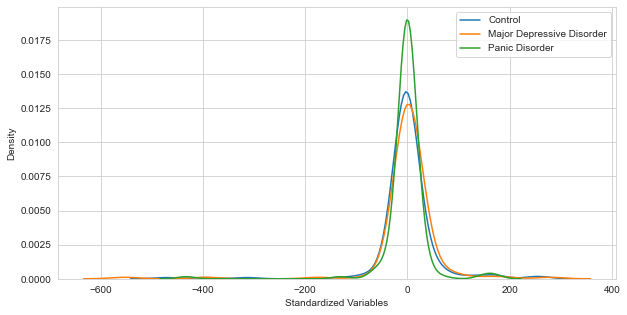

In [98]:
plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
plt.grid(True)
plt.xlabel('Standardized Variables',fontsize=10)
plt.ylabel('Density',fontsize=10)

sns.kdeplot(CON)
sns.kdeplot(MDD)
sns.kdeplot(PD)

# plt.legend()
plt.legend(['Control', 'Major Depressive Disorder', 'Panic Disorder'], fontsize=10)

In [38]:
SDNN = hrv_only['b1SDNN']
NN50 = hrv_only['b1NN50']
PNN50 = hrv_only['b1PNN50']
RMSSD = hrv_only['b1RMSSD']
VLF = hrv_only['b1VLF']
LF = hrv_only['b1LF']
HF = hrv_only['b1HF']
LFHF = hrv_only['b1LF/HF']
POWER = hrv_only['b1POWER']
RESP = hrv_only['b1RESP']
TEMP = hrv_only['b1TEMP']
HR = hrv_only['b1HR']

* All variables

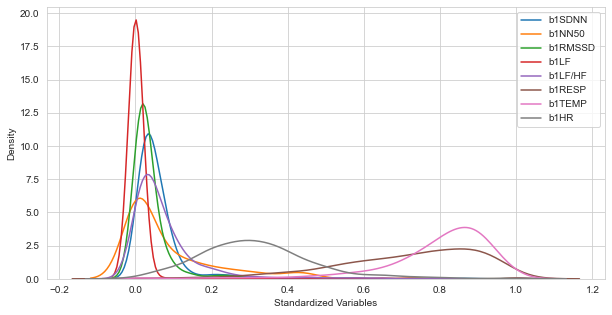

In [44]:
plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
plt.grid(True)
plt.xlabel('Standardized Variables',fontsize=10)
plt.ylabel('Density',fontsize=10)

sns.kdeplot(b1SDNN)
sns.kdeplot(b1NN50)
sns.kdeplot(b1RMSSD)
# sns.kdeplot(b1VLF)
sns.kdeplot(b1LF)
# sns.kdeplot(b1HF)
sns.kdeplot(b1LFHF)
# sns.kdeplot(b1POWER)
# sns.kdeplot(b1PNN50)
sns.kdeplot(b1RESP)
sns.kdeplot(b1TEMP)
sns.kdeplot(b1HR)

# plt.legend()
plt.legend(['b1SDNN', 'b1NN50', 'b1RMSSD', 'b1LF', 'b1LF/HF', 'b1RESP', 'b1TEMP', 'b1HR'], fontsize=10)

- - -

# Data Analysis

## Data Selection

In [ ]:
X = hrv_b1_s_sub
Y = hrv_disorder

In [ ]:
var_selection = ["SDNN", "NN50","PNN50", "RMSSD", "LF", "HF", "LF/HF", "HR"] ## Choose the variables that must be adopted for input values
X = X.loc[:,var_selection]

In [ ]:
## Generating dataset with y label on it. 
hrv_data = pd.concat([hrv_s_r_sub, hrv_disorder], axis=1)

In [ ]:
hrv_data.head()

## Train-Test Split

In [ ]:
X.columns

In [ ]:
## Split X and Y into training dataset and test dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [ ]:
print("x_train dataset shape is", x_train.shape)
print("y_train dataset shape is", y_train.shape)

print("x_test dataset shape is", x_test.shape)
print("y_test dataset shape is", y_test.shape)

In [ ]:
## Converting dataframe format into numpy array
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
## Use TensorDataset to create dataset with ndarray
train_dataset = TensorDataset(torch.tensor(x_train_np), torch.tensor(y_train_np))
test_dataset = TensorDataset(torch.tensor(x_test_np), torch.tensor(y_test_np))

In [ ]:
## Setting trainloader and testloader for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

- - -

## Regression

In [ ]:
logistic_reg = LogisticRegression(solver='lbfgs', max_iter = 4000)
logistic_reg.fit(x_train, y_train.values.ravel())

In [ ]:
predictions = logistic_reg.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,predictions))

- - -

## Decision Tree

In [ ]:
dt_model=DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

In [ ]:
dt_pred = dt_model.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,dt_pred))

In [ ]:
print(classification_report(y_test,dt_pred))

- - -

## Random Forest Classification

In [ ]:
rf= RandomForestClassifier(n_estimators=5000)
rf.fit(x_train, y_train.values.ravel())

In [ ]:
rf_pre=rf.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, rf_pre))

In [ ]:
print(classification_report(y_test, rf_pre))

- - -

## XGBoosts Classifier

In [ ]:
xgboost = XGBClassifier(n_estimators=1000, eval_metric='mlogloss')
xgboost.fit(x_train, y_train)

In [ ]:
xg_pred = xgboost.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, xg_pred))

In [ ]:
print(classification_report(y_test, xg_pred))

- - -

## Multi-Layer Perceptron

* Simple MLP

In [ ]:
input_size = x_train.shape[1]

In [ ]:
class MLP_HRV(nn.Module):
    def __init__(self):
        super(MLP_HRV, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model = MLP_HRV().to(DEVICE)
print(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
x_train = torch.tensor(x_train.values)

In [ ]:
for epoch in range(args.epochs):
    loss = 0
    batch = len(train_loader)

    for images, labels in train_loader: 
        images = images.view(-1, input_size).to(DEVICE) 
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        hypothesis = model(images)
        cost = criterion(hypothesis, labels)
        cost.backward()
        optimizer.step()
        loss += cost / batch

    print('Epoch:', '%03d' % (epoch + 1), 'Training loss =', '{:.5f}'.format(loss))

- - -

## Convolutional Neural Network

In [ ]:
print("X shape is ", X.shape)
print("Y shape is ", Y.shape)

In [ ]:
X.head()